In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
col_names=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack"]
len(col_names)

42

In [55]:
train_dataset=pd.read_csv('/content/drive/MyDrive/nsldata/NSL_KDD_Train.csv',header=None,names=col_names)
test_dataset=pd.read_csv('/content/drive/MyDrive/nsldata/NSL_KDD_Test.csv',header=None,names=col_names)

In [150]:
test_dataset=pd.read_csv('/content/drive/MyDrive/nsldata/NSL_KDD_Test.csv',header=None,names=col_names)

In [56]:
train_dataset.loc[train_dataset['attack'] =="normal", 'attack'] = 0
train_dataset.loc[train_dataset['attack'] !=0, 'attack'] = 1

In [57]:
data=train_dataset

In [58]:
data.loc[data['attack'] =="normal", 'attack'] = 0
data.loc[data['attack'] !=0, 'attack'] = 1
data["attack"].value_counts()

0    67343
1    58630
Name: attack, dtype: int64

In [59]:
df_attack=data.loc[data['attack'] == 1]
df_minority_data=data.loc[data['attack'] == 1]
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'attack']

In [68]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers import LeakyReLU,ReLU
from keras.layers import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

In [61]:
from sklearn.preprocessing import StandardScaler
numerical_df = df_minority_data_withouttv.select_dtypes("number")
categorical_df = df_minority_data_withouttv.select_dtypes("object")
scaling = StandardScaler()
numerical_df_rescaled = scaling.fit_transform(numerical_df)
get_dummy_df = pd.get_dummies(categorical_df)

In [62]:
protocol_dummy_col = [col for col in get_dummy_df.columns if 'protocol_type' in col]
protocol_dummy = get_dummy_df[protocol_dummy_col]
service_dummy_col = [col for col in get_dummy_df.columns if 'service' in col]
service_dummy = get_dummy_df[service_dummy_col]
flag_dummy_col = [col for col in get_dummy_df.columns if 'flag' in col]
flag_dummy = get_dummy_df[flag_dummy_col]

get_dummy_df.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [63]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(numerical_df_rescaled)

numerical_df_rescaled = imputer.transform(numerical_df_rescaled)

In [87]:
def define_generator (catsh1,catsh2,catsh3,numerical):
  #Inputting noise  from latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8)(noise)
    hidden_1 = ReLU(0.2)(hidden_1)
    #hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)
    hidden_2 = Dense(16)(hidden_1)
    hidden_2 = ReLU(0.2)(hidden_2)
    #hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating location data

    branch_1 = Dense(32)(hidden_2)
    branch_1 = ReLU(0.2)(branch_1)
    #branch_1 = BatchNormalization(momentum = 0.8)(branch_1)
    branch_1 = Dense(64)(branch_1)
    branch_1 = ReLU(0.2)(branch_1)
    #branch_1 = BatchNormalization(momentum=0.8)(branch_1)

    #Output Layer1
    branch_1_output = Dense(catsh1, activation = "softmax")(branch_1)

    #Likewise, for all remaining 2 categories branches will be defined
    branch_2_output = Dense(catsh2, activation = "softmax")(branch_1)
    branch_3_output = Dense(catsh3, activation = "softmax")(branch_1)

    #Branch 12 for generating numerical data
    branch_12 = Dense(64)(hidden_2)
    branch_12 = ReLU(0.2)(branch_12)
    #branch_12 = BatchNormalization(momentum=0.8)(branch_12)
    branch_12 = Dense(128)(branch_12)
    branch_12 = ReLU(0.2)(branch_12)
    #branch_12 = BatchNormalization(momentum=0.8)(branch_12)

    #Output Layer12
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)

    #Combined output
    combined_output = concatenate([branch_1_output,branch_2_output,branch_3_output, branch_12_output])

    #Return model

    return Model(inputs = noise, outputs = combined_output)



In [88]:
generator = define_generator(protocol_dummy.shape[1],service_dummy.shape[1],flag_dummy.shape[1],numerical_df_rescaled.shape[1])
generator.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 dense_103 (Dense)           (None, 8)                    808       ['input_17[0][0]']            
                                                                                                  
 re_lu_22 (ReLU)             (None, 8)                    0         ['dense_103[0][0]']           
                                                                                                  
 dense_104 (Dense)           (None, 16)                   144       ['re_lu_22[0][0]']            
                                                                                           

In [126]:
def define_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128)(d_input)
    d = ReLU(0.2)(d)
    d=BatchNormalization(momentum = 0.8)(d)
    d = Dense(64)(d)
    d = ReLU(0.2)(d)
    d=BatchNormalization(momentum = 0.8)(d)
    d = Dense(32)(d)
    d = ReLU(0.2)(d)
    d=BatchNormalization(momentum = 0.8)(d)
    d = Dense(16)(d)
    d = ReLU(0.2)(d)
    d=BatchNormalization(momentum = 0.8)(d)
    d = Dense(8)(d)
    d = ReLU(0.2)(d)
    d=BatchNormalization(momentum = 0.8)(d)

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer ="adam", metrics = ["accuracy"])
    return model

In [127]:
inputs_n = protocol_dummy.shape[1]+service_dummy.shape[1]+flag_dummy.shape[1]+numerical_df_rescaled.shape[1]
discriminator = define_discriminator(inputs_n)
discriminator.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 118)]             0         
                                                                 
 dense_151 (Dense)           (None, 128)               15232     
                                                                 
 re_lu_59 (ReLU)             (None, 128)               0         
                                                                 
 batch_normalization_27 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_152 (Dense)           (None, 64)                8256      
                                                                 
 re_lu_60 (ReLU)             (None, 64)                0         
                                                          

In [128]:
def define_complete_gan(generator, discriminator):
    discriminator.trainable = False
    gan_output = discriminator(generator.output)

    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = "adam")
    return model

In [129]:
completegan = define_complete_gan(generator, discriminator)

In [119]:
import matplotlib.pyplot as plt

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
Epoch: 2200 [Discriminator loss: 0.693167] [Generator loss: 0.693841]
1/1 [==============================] - 0s 18ms/step
Epoch: 2400 [Discriminator loss: 0.693188] [Generator loss: 0.693497]
1/1 [==============================] - 0s 23ms/step
Epoch: 2600 [Discriminator loss: 0.693209] [Generator loss: 0.693782]
1/1 [==============================] - 0s 23ms/step
Epoch: 2800 [Discriminator loss: 0.693207] [Generator loss: 0.692608]
1/1 [==============================] - 0s 20ms/step
Epoch: 3000 [Discriminator loss: 0.693162] [Generator loss: 0.693145]
1/1 [==============================] - 0s 33ms/step
Epoch: 3200 [Discriminator loss: 0.693161] [Generator loss: 0.693275]
1/1 [==============================] - 0s 19ms/step
Epoch: 3400 [Discriminator loss: 0.693161] [Generator loss: 0.692673]
1/1 [==============================] - 0s 30ms/step
Epoch: 3600 [Discriminator loss: 0.693161] 

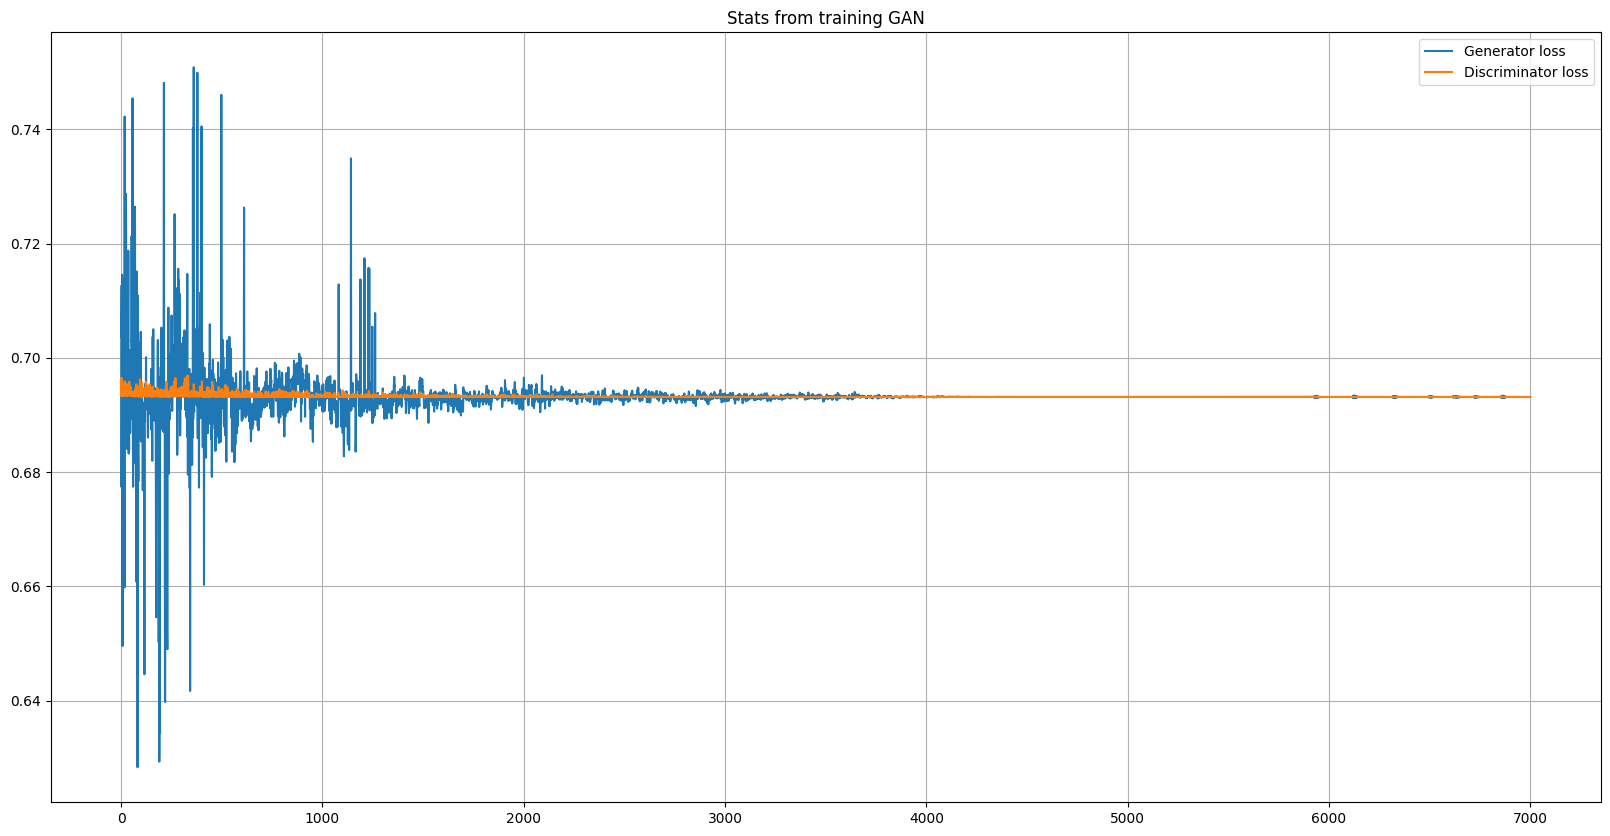

In [131]:
from zmq.constants import Flag
def gan_train(gan, generator, discriminator, catsh1,catsh2,catsh3,numerical, latent_dim, n_epochs, n_batch, n_eval):
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)
    discriminator_loss = []
    generator_loss = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))

    #training
    for i in range(n_epochs):
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, catsh1.shape[0], half_batch)
        protocol_real = catsh1[idx]
        service_real = catsh2[idx]
        flag_real = catsh3[idx]
        numerical_real = numerical_df_rescaled[idx]

        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([protocol_real, service_real, flag_real,numerical_real], axis = 1)

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))

    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

latent_dim = 100
gan_train(completegan, generator, discriminator, protocol_dummy.values,service_dummy.values,flag_dummy.values,numerical_df_rescaled, latent_dim, n_epochs = 7000, n_batch = 64, n_eval = 200)

In [153]:
noise = np.random.normal(0, 1, (8713, 100))
generated_mixed_data = generator.predict(noise)
#print(generated_mixed_data)
columns=list(protocol_dummy.columns)+list(service_dummy.columns)+list(flag_dummy.columns)+list(numerical_df.columns)
#columns
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df

273/273 [==============================] - 1s 3ms/step


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
1,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
2,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
3,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
4,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.084151,0.023016,0.113377,0.016950,0.024106,0.368220,0.019476,0.030227,0.943319,0.008115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8708,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
8709,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080542,0.022603,0.116849,0.015975,0.023508,0.376154,0.019188,0.029724,0.942477,0.007902
8710,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905
8711,0.0115,0.983597,0.004902,0.000573,0.000086,0.001044,0.004007,0.000193,0.000197,0.000219,...,0.080611,0.022614,0.116872,0.015992,0.023535,0.375855,0.019187,0.029758,0.942466,0.007905


In [154]:
original_df = pd.concat([protocol_dummy,service_dummy,flag_dummy,numerical_df], axis = 1)
Numeric_columns=numerical_df.columns
protocol_filter_col = [col for col in mixed_gen_df if col.startswith('protocol')]
protocol=mixed_gen_df[protocol_filter_col]
protocol= pd.get_dummies(protocol).idxmax(1)
protocol= protocol.replace('protocol_type_', '', regex=True)
df_generated_data = pd.DataFrame()
df_generated_data['protocol']=protocol

In [155]:
service_filter_col = [col for col in mixed_gen_df if col.startswith('service')]
service=mixed_gen_df[service_filter_col]
service= pd.get_dummies(service).idxmax(1)
service= service.replace('service_', '', regex=True)

df_generated_data['service']=service

flag_filter_col = [col for col in mixed_gen_df if col.startswith('flag')]
flag=mixed_gen_df[flag_filter_col]
flag= pd.get_dummies(flag).idxmax(1)
flag= flag.replace('flag_', '', regex=True)

df_generated_data['flag']=flag

df_generated_data

,protocol,service,flag
0,tcp,link,S2
1,tcp,link,S2
2,tcp,link,S2
3,tcp,link,S2
4,tcp,link,S2
...,...,...,...
8708,tcp,link,S2
8709,tcp,link,S2
8710,tcp,link,S2
8711,tcp,link,S2


In [156]:
ncols=numerical_df.columns
for col in ncols:
  df_generated_data[col]=mixed_gen_df[col]
df_generated_data.shape


(8713, 41)

In [157]:
df_generated_data['attack']=1
df_generated_data = df_generated_data.fillna(np.nan,axis=0)

In [158]:
from sklearn import preprocessing
encoder_protocol = preprocessing.LabelEncoder()
encoder_service = preprocessing.LabelEncoder()
encoder_flag= preprocessing.LabelEncoder()
df=data
df = df.fillna(np.nan,axis=0)
df['protocol_type'] = encoder_protocol.fit_transform(df['protocol_type'].astype(str))
df['service'] = encoder_service.fit_transform(df['service'].astype(str))
df['flag'] = encoder_flag.fit_transform(df['flag'].astype(str))
df_generated_data['protocol_type'] = encoder_protocol.transform(df_generated_data['protocol'].astype(str))
df_generated_data['service'] = encoder_service.transform(df_generated_data['service'].astype(str))
df_generated_data['flag'] = encoder_flag.transform(df_generated_data['flag'].astype(str))

In [159]:
X1 = df_generated_data.loc[:, df_generated_data.columns != 'attack']
Y1 = df_generated_data['attack']

#Seperate TV in Original Data
X = df.loc[:, df.columns != 'attack']
Y = df['attack'].astype(int)

X1=X1.drop("protocol",axis=1)

In [160]:
X_train=X
Y_train=Y

X_train=X_train.append(X1)
Y_train=Y_train.append(Y1)

<ipython-input-160-7685c3f20a7c>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X1)
<ipython-input-160-7685c3f20a7c>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y_train=Y_train.append(Y1)


In [161]:
import torch as tch
from scipy.io import arff

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


In [172]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Input(shape=(41,)),  # Input layer with 41 features
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
    layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
    #layers.Dense(16, activation='relu'),
    #layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
2105/2105 [==============================] - 8s 3ms/step - loss: 1084.7773 - accuracy: 0.8993
Epoch 2/10
2105/2105 [==============================] - 5s 2ms/step - loss: 577.1765 - accuracy: 0.9378
Epoch 3/10
2105/2105 [==============================] - 4s 2ms/step - loss: 958.4382 - accuracy: 0.9427
Epoch 4/10
2105/2105 [==============================] - 4s 2ms/step - loss: 515.2310 - accuracy: 0.9559
Epoch 5/10
2105/2105 [==============================] - 5s 3ms/step - loss: 1154.3958 - accuracy: 0.9593
Epoch 6/10
2105/2105 [==============================] - 4s 2ms/step - loss: 1492.1306 - accuracy: 0.9623
Epoch 7/10
2105/2105 [==============================] - 4s 2ms/step - loss: 878.0037 - accuracy: 0.9625
Epoch 8/10
2105/2105 [==============================] - 6s 3ms/step - loss: 2359.5317 - accuracy: 0.9614
Epoch 9/10
2105/2105 [==============================] - 4s 2ms/step - loss: 2289.4255 - accuracy: 0.9467
Epoch 10/10
2105/2105 [==============================] - 5s

In [151]:
test_dataset.loc[test_dataset['attack'] =="normal", 'attack'] = 0
test_dataset.loc[test_dataset['attack'] !=0, 'attack'] = 1

from sklearn.preprocessing import LabelEncoder

cols = ['protocol_type','service','flag']

for i in cols:
    en = LabelEncoder()

    test_dataset[i] = en.fit_transform(test_dataset[i])
X_test=test_dataset.drop(["attack"],axis=1)
Y_test=test_dataset["attack"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_test= scaler.fit_transform(X_test)
Y_test=Y_test.to_numpy()
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [175]:
test_results = model.evaluate(X_test, Y_test, verbose=1)

705/705 [==============================] - 1s 2ms/step - loss: 7.5564 - accuracy: 0.8202
